

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Overfitting an Artificial Neural Network (ANN)

#### Aun Al Ghaithi
#### PGE Department, The University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Lei Liu, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)



### Executive summary
The challenge is to test ANNs for overfit potential on a noisy dataset. An unconventional subsurface dataset was used to assess the concept. Oil production was predicted using selected predictor features from the dataset. The results show that ANNs overfit when the number of neurons, or the training duration are increased significantly, or if the learning rate is reduced below the tuned value. The recommendation is to avoid overcomplicating the ANN model to prevent overfitting.

### Import Packages

In [7]:
import geostatspy.GSLIB as GSLIB                            # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                      # GSLIB methods convert to Python        

import numpy as np                                          # ndarrys for gridded data
import pandas as pd                                         # DataFrames for tabular data
import os                                                   # set working directory, run executables
import matplotlib.pyplot as plt                             # for plotting
from scipy import stats                                     # summary statistics
import math                                                 # trig etc.
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.naive_bayes import GaussianNB                  # naive Bayes model and prediction
from sklearn import metrics                                 # measures to check our modelscmap
cmap = plt.cm.inferno                                       # inferno color map!
import warnings
warnings.filterwarnings("ignore")                           # suppress warnings

import numpy as np                                                     # ndarrys for gridded data
import pandas as pd                                                    # DataFrames for tabular data
import os                                                              # set working directory, run executables
import matplotlib.pyplot as plt                                        # for plotting
import matplotlib.image as mpimg 
import seaborn as sns                                                  # for plotting
import warnings                                                        # supress warnings from seaborn pairplot
from sklearn.model_selection import train_test_split                   # train / test DatFrame split
from sklearn.pipeline import Pipeline                                  # for polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from IPython.core.display import display, Javascript, clear_output
from IPython.display import Markdown as md
%matplotlib inline                        

### Functions

Let's define a function to streamline plotting correlation matrices for the ANN regression model.

The following code block is modified after Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

In [8]:
def plot_corr(dataframe,size=10):                               # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

### Load Data

Load the "unconv_MV_v5.csv" comma delimited file from https://github.com/GeostatsGuy/GeoDataSets. 

In [9]:
my_data = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v5.csv") # load the data from Dr. Pyrcz's github repository

In [10]:
my_data.head(n=13)                                          # preview the first n rows of the DataFrame

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832
5,6,14.53,4.81,2.69,53.60,0.94,1.67,4395.763259
6,7,13.49,3.60,2.93,63.71,0.80,1.85,4104.400989
7,8,11.58,3.03,3.25,53.00,0.69,1.93,3496.742701
8,9,12.52,2.72,2.43,65.77,0.95,1.98,4025.851153
9,10,13.25,3.94,3.71,66.20,1.14,2.65,4285.026122


Add noise

The following code block is modified after Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

In [11]:
np.random.seed(seed = 13)                                 # set the random number seed
noise_stdev = 500
my_data['Prod'] = my_data['Prod'] + np.random.normal(loc=0.0,scale=noise_stdev,size = len(my_data))

Remove the well index and check the summary summary statistics.

In [12]:
my_data = my_data.iloc[:,1:]                                # remove the well index
my_data.describe().transpose()                              # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.07000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.03500,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.95500,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.51000,58.262500,84.330000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.03000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.96000,2.142500,2.870000
Prod,200.0,4289.442798,1050.801635,1971.849921,3584.756335,4271.54616,4963.181397,7094.030832


### Overfitting an Artificial Neural Network (ANN)

Summary the workflow:

1. Calculate the correlation matrix and Feature Selection

2. Data Normalization

3. Train and Test Split

4. Train the Model

5. Hyper Parameter Tuning using k-fold Cross Validation

6. Hyper Parameter Tuning using k-fold Cross Validation 2nd Method

7. Train and Predict After Hyperparameter Tuning

Results and Overfiting the ANN Model





### 1. Calculate the correlation matrix and Feature Selection
The correlation coefficient matrix was utilized to identify predictor features in relation to the production response feature. Production was found to be highly correlated with porosity, permeability, AI, and TOC. These features were retained in the dataframe for further modeling.

In [13]:
corr_matrix = np.corrcoef(my_data.iloc[:,:7], rowvar = False)  # correlation matrix without the categorical value
print(np.around(corr_matrix,2))                           # print the correlation matrix to 2 decimals

[[ 1.    0.76 -0.46 -0.22  0.71  0.11  0.8 ]
 [ 0.76  1.   -0.24 -0.12  0.47  0.05  0.66]
 [-0.46 -0.24  1.    0.13 -0.53  0.5  -0.4 ]
 [-0.22 -0.12  0.13  1.   -0.21  0.32  0.18]
 [ 0.71  0.47 -0.53 -0.21  1.    0.3   0.6 ]
 [ 0.11  0.05  0.5   0.32  0.3   1.    0.25]
 [ 0.8   0.66 -0.4   0.18  0.6   0.25  1.  ]]


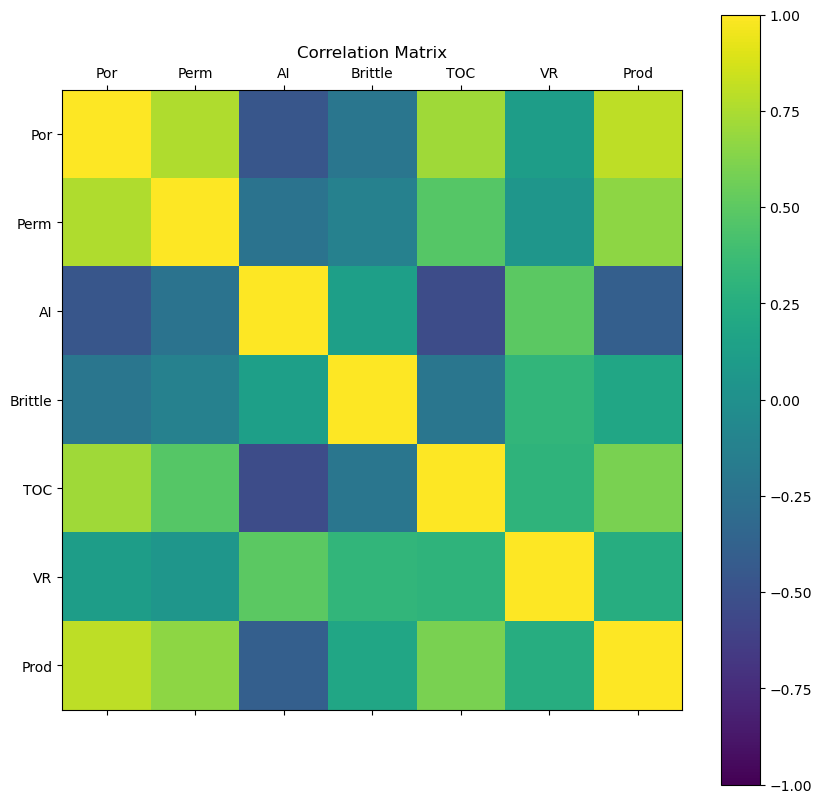

In [14]:
plot_corr(my_data.iloc[:,:7],10)                            # using our correlation matrix visualization function
plt.show()

Apply feature selection using the correlation matrix. Drop the Brittle and VR features from the dataframe.

In [15]:
my_data=my_data.drop(['Brittle','VR'], axis=1)
my_data.describe().transpose()                              # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.07000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.03500,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.95500,3.345000,4.630000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.03000,1.350000,2.180000
Prod,200.0,4289.442798,1050.801635,1971.849921,3584.756335,4271.54616,4963.181397,7094.030832


### 2. Data Normalization
The dataset was normalized using the MinMaxScaler to scale values between 0 and 1 before training the neural network. This step is essential because ANNs require values between 0 and 1 or -1 and 1 to perform effectively. Both the predictor features and the response feature were normalized using two different scalers.

In [16]:
from sklearn.preprocessing import MinMaxScaler

transform_x = MinMaxScaler();
transform_y = MinMaxScaler();

features = ['Por','Perm','AI','TOC']#predictor and response
labels = ['Prod']#predictor and response


my_data['sPor'] = transform_x.fit_transform(my_data.loc[:,features].values)[:,0]
my_data['sPerm'] = transform_x.fit_transform(my_data.loc[:,features].values)[:,1]
my_data['sAI'] = transform_x.fit_transform(my_data.loc[:,features].values)[:,2]
my_data['sTOC'] = transform_x.fit_transform(my_data.loc[:,features].values)[:,3]
my_data['sProd'] = transform_y.fit_transform(my_data.loc[:,labels].values)[:,0]

my_data.head()

,Por,Perm,AI,TOC,Prod,sPor,sPerm,sAI,sTOC,sProd
0,12.08,2.92,2.80,1.16,3809.000860,0.325294,0.204805,0.453731,0.569620,0.358666
1,12.38,3.53,3.22,0.89,3938.029394,0.342941,0.274600,0.579104,0.455696,0.383856
2,14.02,2.59,4.01,0.89,4262.097035,0.439412,0.167048,0.814925,0.455696,0.447123
3,17.67,6.75,2.63,1.08,5324.587038,0.654118,0.643021,0.402985,0.535865,0.654553
4,17.52,4.57,3.18,1.51,4078.683686,0.645294,0.393593,0.567164,0.717300,0.411316


### 3. Train and Test Split
The data set was split into 80% training data and 20% as withheld testing data.


In [17]:
X2 = my_data.iloc[:,[0,1,2,3,5,6,7,8]]            # extract the predictor feature
y2 = my_data.iloc[:,[4,9]]                        # extract the response feature
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=73073)

In [18]:
X_train.describe().transpose()                         # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,160.0,14.942250,3.004975,6.55,12.830000,15.070000,17.402500,23.55
Perm,160.0,4.347437,1.721018,1.13,3.090000,4.100000,5.370000,9.87
AI,160.0,3.001562,0.592084,1.28,2.557500,3.015000,3.415000,4.63
TOC,160.0,0.982437,0.497502,-0.19,0.592500,1.040000,1.370000,2.18
sPor,160.0,0.493662,0.176763,0.00,0.369412,0.501176,0.638382,1.00
sPerm,160.0,0.368128,0.196913,0.00,0.224256,0.339817,0.485126,1.00
sAI,160.0,0.513899,0.176741,0.00,0.381343,0.517910,0.637313,1.00
sTOC,160.0,0.494699,0.209916,0.00,0.330169,0.518987,0.658228,1.00


In [19]:
X_test.describe().transpose()                         # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,40.0,15.186750,2.860369,7.770000,13.480000,15.075000,17.130000,20.960000
Perm,40.0,4.264000,1.791149,1.480000,3.265000,3.860000,5.012500,9.580000
AI,40.0,2.838000,0.434264,1.860000,2.450000,2.810000,3.200000,3.810000
TOC,40.0,1.022500,0.415974,0.080000,0.790000,1.000000,1.307500,2.080000
sPor,40.0,0.508044,0.168257,0.071765,0.407647,0.501471,0.622353,0.847647
sPerm,40.0,0.358581,0.204937,0.040046,0.244279,0.312357,0.444222,0.966819
sAI,40.0,0.465075,0.129631,0.173134,0.349254,0.456716,0.573134,0.755224
sTOC,40.0,0.511603,0.175517,0.113924,0.413502,0.502110,0.631857,0.957806


In [20]:
y_train.describe()[:2]                                    # calculate summary statistics for the data

,Prod,sProd
count,160.000000,160.000000
mean,4253.134035,0.445374


In [21]:
y_test.describe()[:2]                                    # calculate summary statistics for the data

,Prod,sProd
count,40.000000,40.000000
mean,4434.677851,0.480816


In [22]:
pormin = 5.0; pormax = 25.0                                 # set minumums and maximums for visualization 
Permmin = 0.0; sPermmax = 10.0
prodmin = 1500.0; prodmax = 8000.0

The univariate statistics for the input features and the output feature are checked. Below is an example showing porosity and permeability as input features, and production as the output feature. The data distributions are well-behaved for the training and testing splits

The following code block is modified after Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

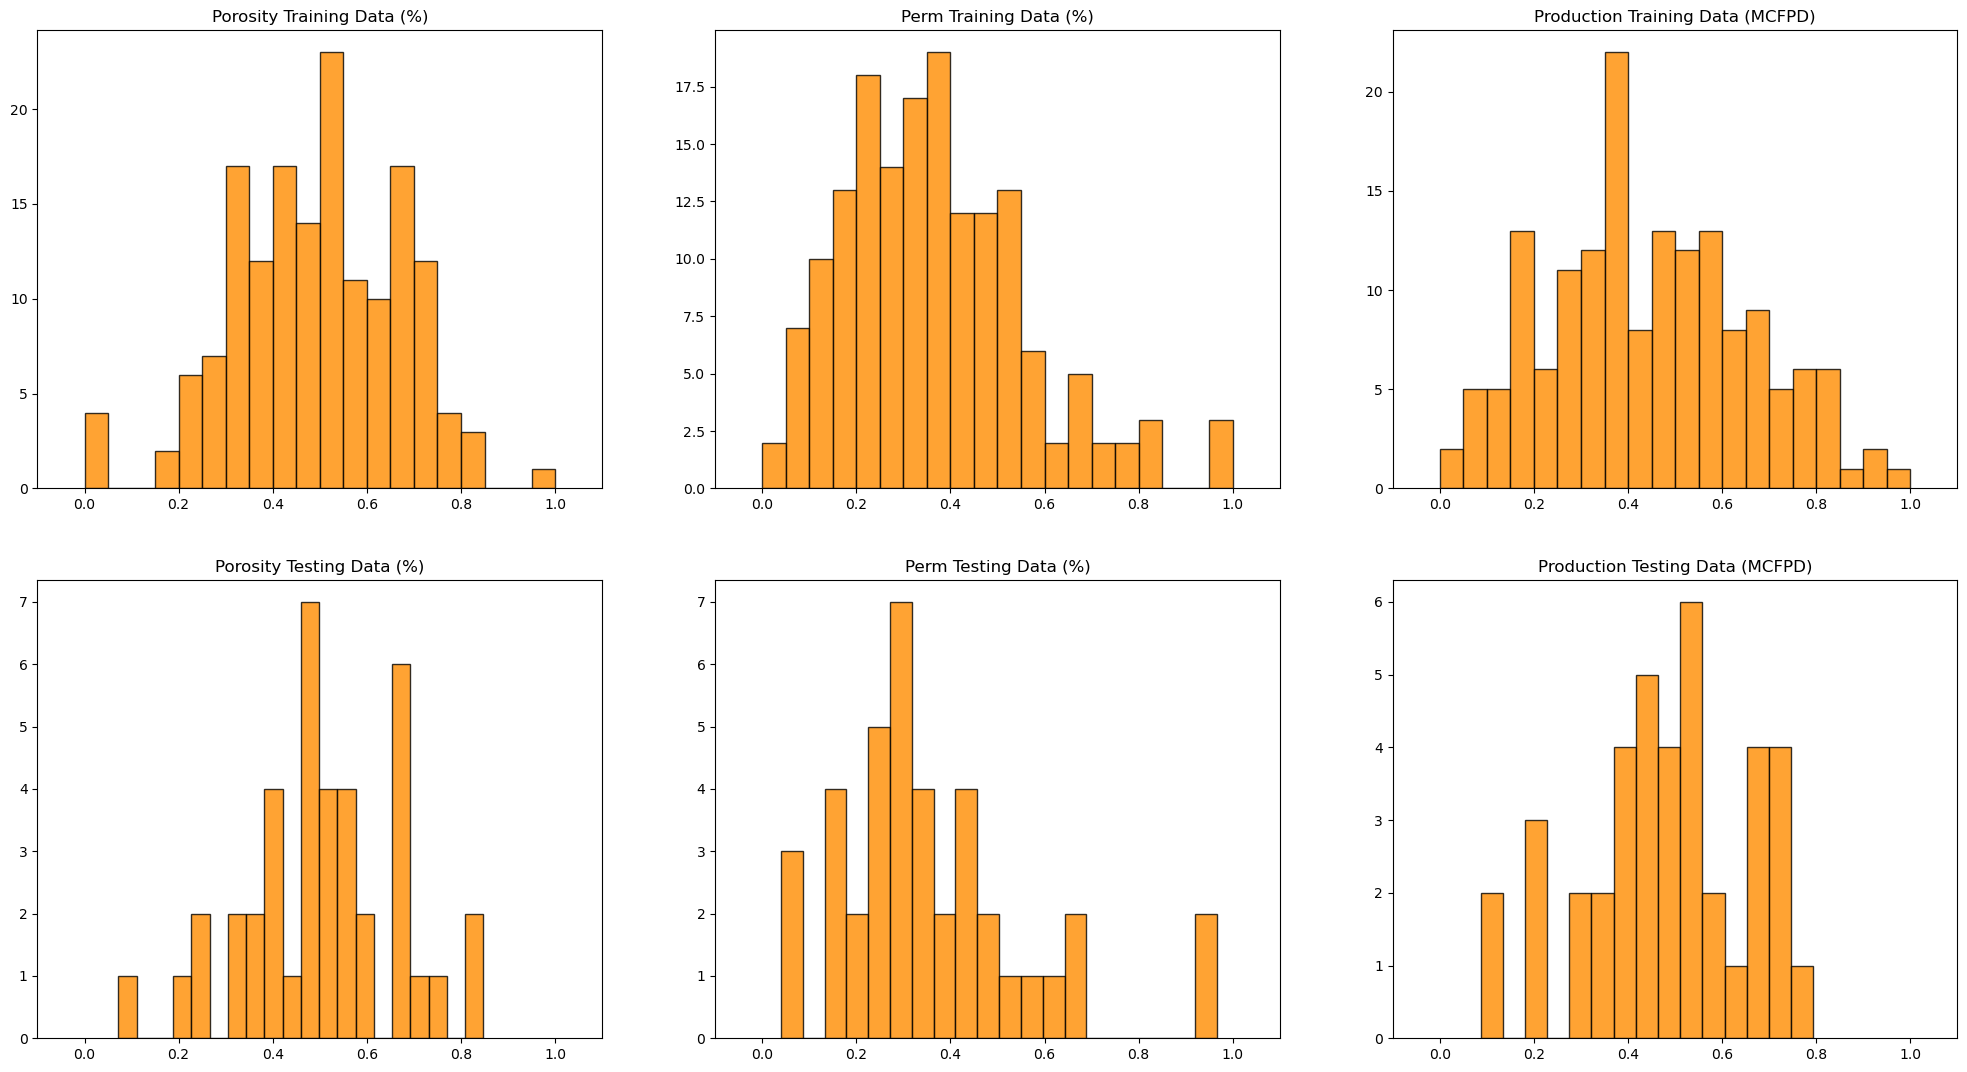

In [23]:
plt.subplot(231)
plt.hist(X_train["sPor"], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20)
plt.title('Porosity Training Data (%)'); plt.xlim(-.1,1.1)

plt.subplot(232)
plt.hist(X_train["sPerm"], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20)
plt.title('Perm Training Data (%)'); plt.xlim(-.1,1.1)

plt.subplot(233)
plt.hist(y_train['sProd'], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20)
plt.title('Production Training Data (MCFPD)'); plt.xlim(-.1,1.1)

plt.subplot(234)
plt.hist(X_test["sPor"], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20)
plt.title('Porosity Testing Data (%)'); plt.xlim(-.1,1.1)

plt.subplot(235)
plt.hist(X_test["sPerm"], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20)
plt.title('Perm Testing Data (%)'); plt.xlim(-.1,1.1)

plt.subplot(236)
plt.hist(y_test['sProd'], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=15)
plt.title('Production Testing Data (MCFPD)'); plt.xlim(-.1,1.1)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.1, wspace=0.2, hspace=0.2)
plt.show()

In [24]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_train:", X_test.shape)
print("Shape of X_train:", y_train.shape)
print("Shape of X_train:", y_test.shape)

Shape of X_train: (160, 8)
Shape of X_train: (40, 8)
Shape of X_train: (160, 2)
Shape of X_train: (40, 2)


In [25]:
type(y_train['sProd'])

pandas.core.series.Series

In [26]:
X_train

,Por,Perm,AI,TOC,sPor,sPerm,sAI,sTOC
91,7.38,1.88,2.54,0.38,0.048824,0.085812,0.376119,0.240506
129,17.21,4.62,2.79,1.52,0.627059,0.399314,0.450746,0.721519
182,9.88,2.72,3.64,0.52,0.195882,0.181922,0.704478,0.299578
17,15.58,3.67,2.53,1.35,0.531176,0.290618,0.373134,0.649789
53,11.98,2.75,4.63,0.76,0.319412,0.185355,1.000000,0.400844
...,...,...,...,...,...,...,...,...
103,18.90,4.57,2.65,1.06,0.726471,0.393593,0.408955,0.527426
164,17.98,4.26,2.94,0.90,0.672353,0.358124,0.495522,0.459916
128,12.98,5.26,3.25,0.93,0.378235,0.472540,0.588060,0.472574
124,23.55,8.25,1.28,2.18,1.000000,0.814645,0.000000,1.000000


In [27]:
type(y_test['sProd'].values)

numpy.ndarray

In [28]:
type(X_train[['sPor','sPerm','sAI','sTOC']].values)

numpy.ndarray

### 4. Train the Model
An initial model architecture was used based on experience.

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

# Define the model
model = models.Sequential([
    layers.Dense(4, activation='linear',input_shape=(4,)),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(50, activation='relu'),


    layers.Dense(1, activation='relu') 
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Train the model
history = model.fit(X_train[['sPor','sPerm','sAI','sTOC']], y_train['sProd'], epochs=200, validation_data=(X_test[['sPor','sPerm','sAI','sTOC']], y_test['sProd']))




Epoch 1/200
5/5 [==============================] - 1s 39ms/step - loss: 0.2158 - mae: 0.4105 - val_loss: 0.1602 - val_mae: 0.3683
Epoch 2/200
5/5 [==============================] - 0s 8ms/step - loss: 0.1034 - mae: 0.2663 - val_loss: 0.0515 - val_mae: 0.2022
Epoch 3/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0334 - mae: 0.1451 - val_loss: 0.0124 - val_mae: 0.0828
Epoch 4/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0284 - mae: 0.1370 - val_loss: 0.0181 - val_mae: 0.1030
Epoch 5/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0243 - mae: 0.1228 - val_loss: 0.0116 - val_mae: 0.0827
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0183 - mae: 0.1094 - val_loss: 0.0164 - val_mae: 0.1074
Epoch 7/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0189 - mae: 0.1100 - val_loss: 0.0126 - val_mae: 0.0899
Epoch 8/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0161 - mae: 0.1023 - va

5/5 [==============================] - 0s 6ms/step - loss: 0.0155 - mae: 0.1001 - val_loss: 0.0117 - val_mae: 0.0834
Epoch 65/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0154 - mae: 0.0978 - val_loss: 0.0116 - val_mae: 0.0824
Epoch 66/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0156 - mae: 0.1010 - val_loss: 0.0125 - val_mae: 0.0882
Epoch 67/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0149 - mae: 0.0978 - val_loss: 0.0117 - val_mae: 0.0828
Epoch 68/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0151 - mae: 0.0980 - val_loss: 0.0116 - val_mae: 0.0823
Epoch 69/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0148 - mae: 0.0977 - val_loss: 0.0124 - val_mae: 0.0872
Epoch 70/200
5/5 [==============================] - 0s 9ms/step - loss: 0.0149 - mae: 0.0984 - val_loss: 0.0117 - val_mae: 0.0828
Epoch 71/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0151 - mae: 0.0983 - val_loss

Epoch 127/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0140 - mae: 0.0945 - val_loss: 0.0131 - val_mae: 0.0885
Epoch 128/200
5/5 [==============================] - 0s 9ms/step - loss: 0.0137 - mae: 0.0936 - val_loss: 0.0126 - val_mae: 0.0845
Epoch 129/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0140 - mae: 0.0941 - val_loss: 0.0132 - val_mae: 0.0887
Epoch 130/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0137 - mae: 0.0938 - val_loss: 0.0126 - val_mae: 0.0842
Epoch 131/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0139 - mae: 0.0941 - val_loss: 0.0128 - val_mae: 0.0856
Epoch 132/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0137 - mae: 0.0933 - val_loss: 0.0128 - val_mae: 0.0856
Epoch 133/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0137 - mae: 0.0926 - val_loss: 0.0128 - val_mae: 0.0850
Epoch 134/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0139 - m

5/5 [==============================] - 0s 4ms/step - loss: 0.0126 - mae: 0.0886 - val_loss: 0.0142 - val_mae: 0.0903
Epoch 190/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0133 - mae: 0.0904 - val_loss: 0.0145 - val_mae: 0.0925
Epoch 191/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0130 - mae: 0.0895 - val_loss: 0.0147 - val_mae: 0.0952
Epoch 192/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0128 - mae: 0.0890 - val_loss: 0.0137 - val_mae: 0.0873
Epoch 193/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0128 - mae: 0.0888 - val_loss: 0.0141 - val_mae: 0.0902
Epoch 194/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0126 - mae: 0.0884 - val_loss: 0.0141 - val_mae: 0.0895
Epoch 195/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0127 - mae: 0.0884 - val_loss: 0.0141 - val_mae: 0.0893
Epoch 196/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0131 - mae: 0.0899 - v

The MSE loss curves are well behaved and converge well for both the training and validation datasets. The model was run for 200 epochs.

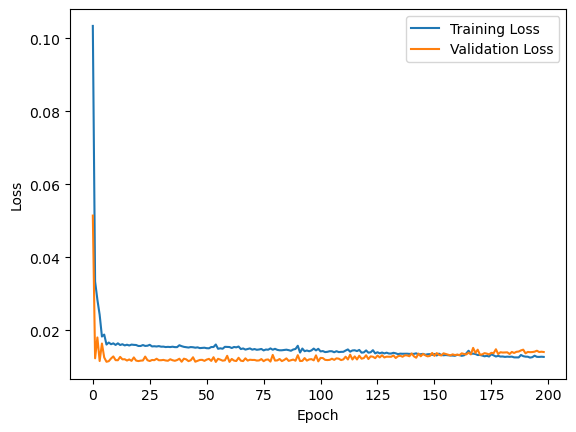

In [30]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The trained ANN is used to predict the training and testing datasets for the predictor feature (production).

In [31]:
# Predict with the NN
pred_norm_prod_test = model.predict(X_test[['sPor','sPerm','sAI','sTOC']]) # predict with our ANN
pred_norm_prod_train = model.predict(X_train[['sPor','sPerm','sAI','sTOC']]) # predict with our ANN

5/5 [==============================] - 0s 0s/step


In [32]:
pred_prod_test = transform_y.inverse_transform(pred_norm_prod_test)

In [33]:
pred_prod_train = transform_y.inverse_transform(pred_norm_prod_train)


In [34]:
print(len(y_train.values))
print(len(pred_norm_prod_train))


160
160


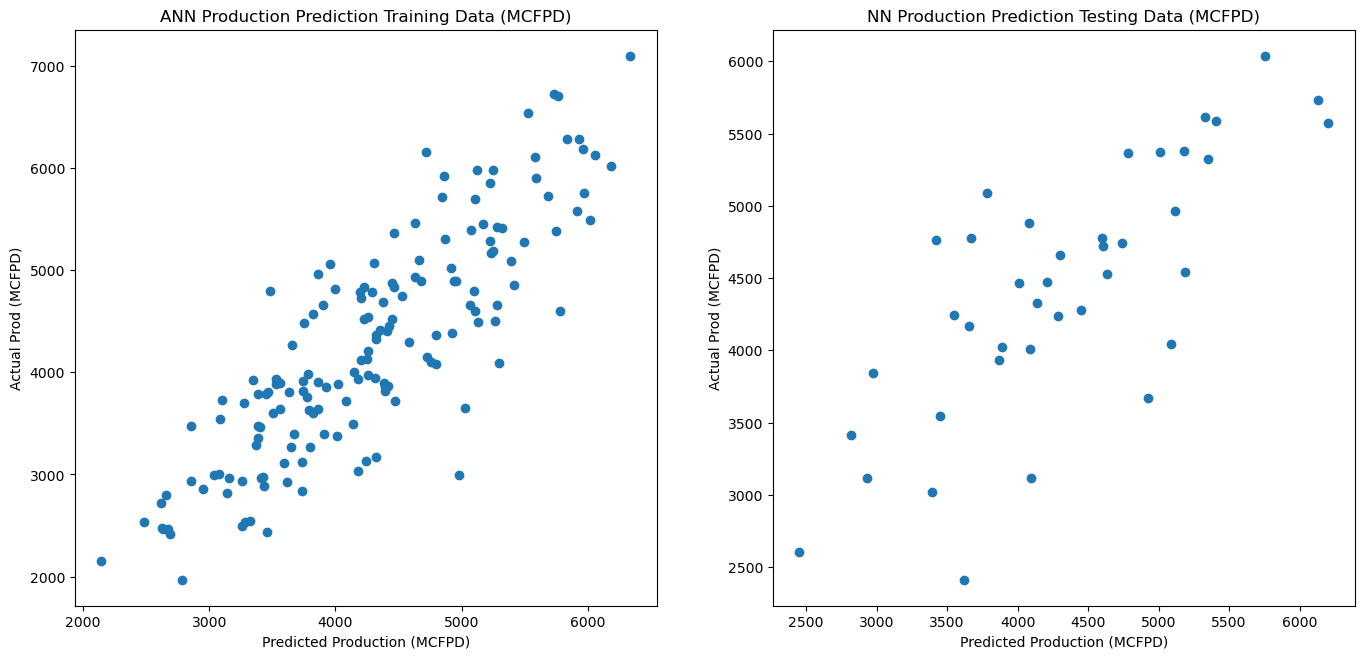

In [35]:
plt.subplot(121)
plt.plot(pred_prod_train,y_train['Prod'].values, 'o', alpha=1.0)
plt.title('ANN Production Prediction Training Data (MCFPD)');plt.xlabel('Predicted Production (MCFPD)'); plt.ylabel('Actual Prod (MCFPD)');

plt.subplot(122)
plt.plot(pred_prod_test,y_test['Prod'].values, 'o', alpha=1.0)
plt.title('NN Production Prediction Testing Data (MCFPD)');plt.xlabel('Predicted Production (MCFPD)'); plt.ylabel('Actual Prod (MCFPD)');
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

The following code block is modified after Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

In [36]:
MSE = metrics.mean_squared_error(y_train['Prod'].values,pred_prod_train)
Var_Explained = metrics.explained_variance_score(y_train['Prod'].values,pred_prod_train)
cor = math.sqrt(metrics.r2_score(y_train['Prod'].values,pred_prod_train))
print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

Mean Squared Error on Training =  324242.55 , Variance Explained = 0.73 Cor = 0.85


In [37]:
MSE = metrics.mean_squared_error(y_test['Prod'].values,pred_prod_test)
Var_Explained = metrics.explained_variance_score(y_test['Prod'].values,pred_prod_test)
cor = math.sqrt(metrics.r2_score(y_test['Prod'].values,pred_prod_test))
print('Mean Squared Error on Testing = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

Mean Squared Error on Testing =  369758.4 , Variance Explained = 0.52 Cor = 0.71


### 5. Hyper Parameter Tuning using k-fold Cross Validation
Several parameters were tested using pipelines to enhance the ANN oil prediction model and to chose a model that would not overfit the data. The goal at this step is to tune the hyperparameters using k-fold cross validation and to produce models that avoid overfitting.

The following code block is modified after Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

In [39]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data
X = my_data.loc[:,['Por','Perm','AI','TOC']]
y = my_data.loc[:,"Prod"]

# Create the Neural Network Model
base_model = MLPRegressor(max_iter=1000)

# Create a Scaler
scaler = MinMaxScaler()

# Create the Pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('model', base_model)
])

# Define Parameter Grid
param_grid = {
    'model__hidden_layer_sizes': [(neurons,) * layers for layers in range(2, 6) for neurons in range(1, 101)],
    'model__activation': ['relu'],
    'model__alpha': [0.0001, 0.001],
    'model__solver': ['adam', 'sgd'],

}

# Choose the Scoring Metric
scoring_metric = 'neg_mean_squared_error'

# Create GridSearchCV Object
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, cv=k_fold, n_jobs=-1)

# Fit the Model
grid_search.fit(X, y)

# Print Best Parameters and Evaluate
print("Best Parameters: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the best model on the full dataset
y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)


Best Parameters:  {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (45, 45, 45), 'model__solver': 'adam'}
Mean Squared Error:  444069.03099303006
Mean Absolute Error:  536.7366863917199


The MSE curve converges nicely. There is no overfit with the selected parameters from the k-fold cross validation.

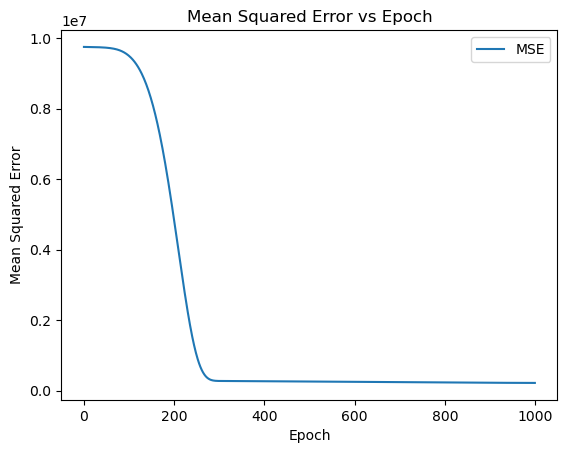

In [40]:
# Access training history
training_history = best_model.named_steps['model'].loss_curve_

# Plot MSE versus epoch
plt.plot(training_history, label='MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs Epoch')
plt.legend()
plt.show()

### 6. Hyper parameter Tuning using k-fold Cross Validation 2nd Method
In this method for k-fold cross-validation, the MinMaxScaler was applied to the response feature (production) to improve the prediction, in additon to the prediction features. Optimal paramters were produced that would train the ANN without overfitting. The next step would try to overfit the data by overcomplicating the ANN.

The following code block is modified after Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

In [41]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data
X = my_data.loc[:,['Por','Perm','AI','TOC']]
y = my_data.loc[:,"Prod"]

# Create the Neural Network Model
base_model = MLPRegressor(max_iter=2000)

# Create a Scaler for input features
input_scaler = MinMaxScaler()

# Create a Scaler for the target variable
target_scaler = MinMaxScaler()

# Fit and transform the input features
X_scaled = input_scaler.fit_transform(X)

# Fit and transform the target variable
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Create the Pipeline
pipeline = Pipeline([
    ('model', base_model)
])

# Define Parameter Grid
param_grid = {
    'model__hidden_layer_sizes': [(neurons,) * layers for layers in range(2, 6) for neurons in range(1, 101)],
    'model__activation': ['relu'],
    'model__alpha': [0.0001, 0.001],
    'model__solver': ['adam', 'sgd'],
}

# Choose the Scoring Metric
scoring_metric = 'neg_mean_squared_error'

# Create GridSearchCV Object
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring_metric, cv=k_fold, n_jobs=-1)

# Fit the Model
grid_search.fit(X_scaled, y_scaled)

# Print Best Parameters and Evaluate
print("Best Parameters: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Access training history for both training and validation (assuming you have a validation set)
training_loss_history = best_model.named_steps['model'].loss_curve_

# Transform the target variable for training
y_scaled = target_scaler.transform(y.values.reshape(-1, 1)).flatten()

# Fit the best model with scaled target
best_model.fit(X_scaled, y_scaled)

# Evaluate the best model on the full dataset
y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)


Best Parameters:  {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (75, 75, 75, 75, 75), 'model__solver': 'adam'}
Mean Squared Error:  19456593.735837784
Mean Absolute Error:  4284.815231846124


In [42]:
len(abs(grid_search.cv_results_['mean_test_score']))


1600

The MSE curve converges nicely, indicating that there is no overfitting with the selected parameters from the k-fold cross-validation. This model architecture was chosen as the final best model to train the ANN.

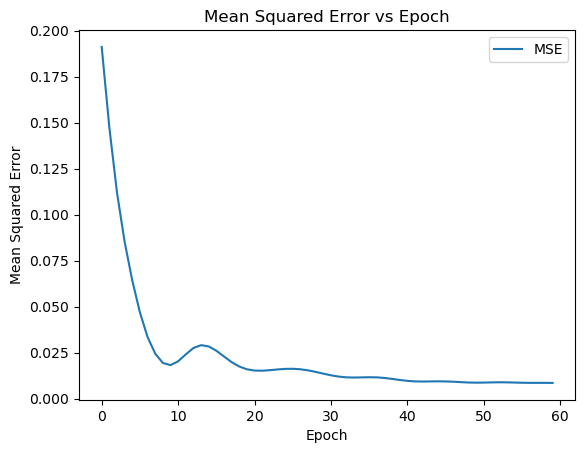

In [43]:
# Access training history
training_history = best_model.named_steps['model'].loss_curve_

# Plot MSE versus epoch
plt.plot(training_history, label='MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs Epoch')
plt.legend()
plt.show()

### 7. Train and Predict After Hyperparameter Tuning
The model hyper parameters from step 5 above were used to train the model and produce ANN prediction that would not overfit the data.


In [46]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

# Define the model
model = models.Sequential([
    layers.Dense(4, activation='linear',input_shape=(4,)),
    layers.Dense(75, activation='relu'),
    layers.Dense(75, activation='relu'),
    layers.Dense(75, activation='relu'),
    layers.Dense(75, activation='relu'),
    layers.Dense(75, activation='relu'),

    layers.Dense(1, activation='relu')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Train the model
history = model.fit(X_train[['sPor','sPerm','sAI','sTOC']], y_train['sProd'], epochs=60, validation_data=(X_test[['sPor','sPerm','sAI','sTOC']], y_test['sProd']))




Epoch 1/60
5/5 [==============================] - 1s 32ms/step - loss: 0.1831 - mae: 0.3731 - val_loss: 0.1132 - val_mae: 0.3017
Epoch 2/60
5/5 [==============================] - 0s 8ms/step - loss: 0.0670 - mae: 0.2057 - val_loss: 0.0171 - val_mae: 0.1064
Epoch 3/60
5/5 [==============================] - 0s 8ms/step - loss: 0.0367 - mae: 0.1570 - val_loss: 0.0260 - val_mae: 0.1260
Epoch 4/60
5/5 [==============================] - 0s 6ms/step - loss: 0.0333 - mae: 0.1493 - val_loss: 0.0148 - val_mae: 0.0978
Epoch 5/60
5/5 [==============================] - 0s 12ms/step - loss: 0.0225 - mae: 0.1246 - val_loss: 0.0205 - val_mae: 0.1231
Epoch 6/60
5/5 [==============================] - 0s 8ms/step - loss: 0.0225 - mae: 0.1230 - val_loss: 0.0130 - val_mae: 0.0918
Epoch 7/60
5/5 [==============================] - 0s 8ms/step - loss: 0.0184 - mae: 0.1112 - val_loss: 0.0113 - val_mae: 0.0843
Epoch 8/60
5/5 [==============================] - 0s 5ms/step - loss: 0.0175 - mae: 0.1059 - val_loss:

There is no overfitting observed from the Mean Squared Error (MSE) training and testing loss curves. The ANN model behaves well.


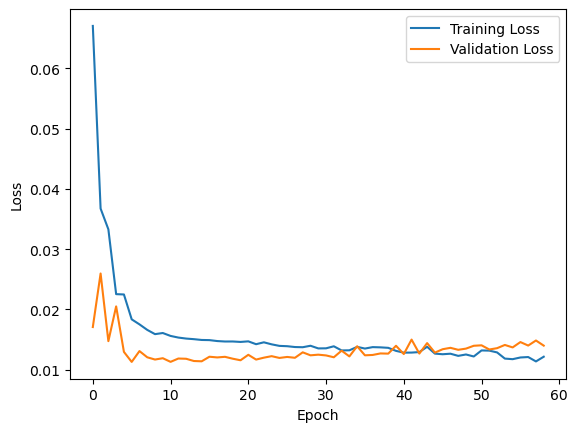

In [47]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
pred_prod_test = transform_y.inverse_transform(pred_norm_prod_test)
pred_prod_train = transform_y.inverse_transform(pred_norm_prod_train)


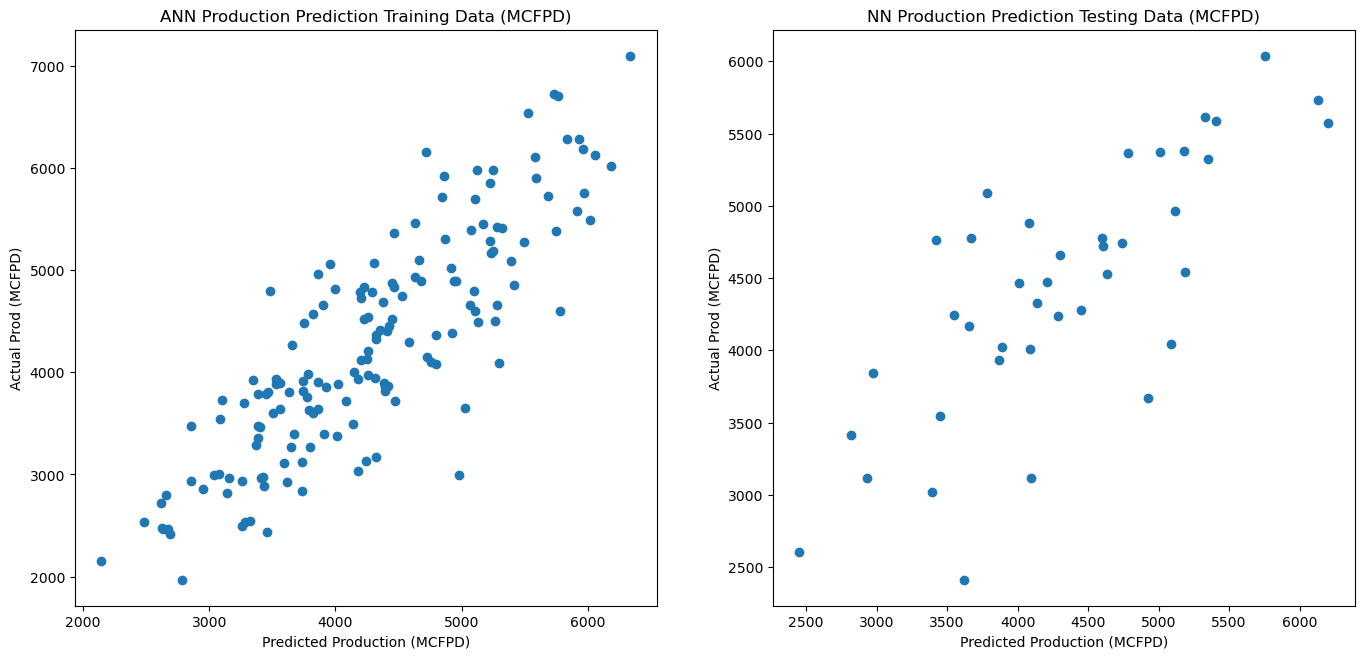

In [49]:
plt.subplot(121)
plt.plot(pred_prod_train,y_train['Prod'].values, 'o', alpha=1.0)
plt.title('ANN Production Prediction Training Data (MCFPD)');plt.xlabel('Predicted Production (MCFPD)'); plt.ylabel('Actual Prod (MCFPD)');

plt.subplot(122)
plt.plot(pred_prod_test,y_test['Prod'].values, 'o', alpha=1.0)
plt.title('NN Production Prediction Testing Data (MCFPD)');plt.xlabel('Predicted Production (MCFPD)'); plt.ylabel('Actual Prod (MCFPD)');
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [50]:
MSE = metrics.mean_squared_error(y_train['Prod'].values,pred_prod_train)
Var_Explained = metrics.explained_variance_score(y_train['Prod'].values,pred_prod_train)
cor = math.sqrt(metrics.r2_score(y_train['Prod'].values,pred_prod_train))
print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

Mean Squared Error on Training =  324242.55 , Variance Explained = 0.73 Cor = 0.85


In [51]:
MSE = metrics.mean_squared_error(y_test['Prod'].values,pred_prod_test)
Var_Explained = metrics.explained_variance_score(y_test['Prod'].values,pred_prod_test)
cor = math.sqrt(metrics.r2_score(y_test['Prod'].values,pred_prod_test))
print('Mean Squared Error on Testing = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

Mean Squared Error on Testing =  369758.4 , Variance Explained = 0.52 Cor = 0.71


### Results and Overfiting the ANN Model
Increasing the number of neurons or layers and decreasing the learning rate tends to overfit the data.

As seen in the validation MSE in the plot below, the curve rises as the epochs increase. The model is performing well on the training data but degrading on the testing data. At this point, the ANN model is overfitting the data. Having an overly complicated ANN model worsens the production prediction and overfits the data. From the k-fold cross-validation and hyperparameter tuning step 5, the model should not contain more than 3-5 hidden layers, and each layer should not include more than 75 neurons. The optimal learning rate is 0.001, and the ANN should not be trained for more than 60 epochs to avoid overfitting. Overcomplicating the ANN model beyond these tuned hyperparameters will overfit the data. The dataset is noisy and does not contain many samples and will overfit if the ANN is complicated beyond the tuned hyperparameters.


In [52]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

# Define the model
model = models.Sequential([
    layers.Dense(4, activation='linear',input_shape=(4,)),
    layers.Dense(200, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(200, activation='relu'),




    layers.Dense(1, activation='relu')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Train the model
history = model.fit(X_train[['sPor','sPerm','sAI','sTOC']], y_train['sProd'], epochs=1000, validation_data=(X_test[['sPor','sPerm','sAI','sTOC']], y_test['sProd']))




Epoch 1/1000
5/5 [==============================] - 1s 32ms/step - loss: 0.1391 - mae: 0.3121 - val_loss: 0.0161 - val_mae: 0.1019
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0442 - mae: 0.1662 - val_loss: 0.0138 - val_mae: 0.0949
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0282 - mae: 0.1356 - val_loss: 0.0312 - val_mae: 0.1518
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0250 - mae: 0.1252 - val_loss: 0.0130 - val_mae: 0.0909
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0215 - mae: 0.1143 - val_loss: 0.0132 - val_mae: 0.0898
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0199 - mae: 0.1119 - val_loss: 0.0158 - val_mae: 0.1041
Epoch 7/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0184 - mae: 0.1063 - val_loss: 0.0120 - val_mae: 0.0849
Epoch 8/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0174 - mae: 0.1

5/5 [==============================] - 0s 12ms/step - loss: 0.0113 - mae: 0.0829 - val_loss: 0.0159 - val_mae: 0.0976
Epoch 64/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0114 - mae: 0.0836 - val_loss: 0.0153 - val_mae: 0.0976
Epoch 65/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0130 - mae: 0.0890 - val_loss: 0.0165 - val_mae: 0.0950
Epoch 66/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0116 - mae: 0.0815 - val_loss: 0.0171 - val_mae: 0.1072
Epoch 67/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0117 - mae: 0.0837 - val_loss: 0.0166 - val_mae: 0.0963
Epoch 68/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0119 - mae: 0.0846 - val_loss: 0.0157 - val_mae: 0.1011
Epoch 69/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0115 - mae: 0.0846 - val_loss: 0.0160 - val_mae: 0.0978
Epoch 70/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0110 - mae: 0.0816 - 

5/5 [==============================] - 0s 6ms/step - loss: 0.0086 - mae: 0.0701 - val_loss: 0.0204 - val_mae: 0.1101
Epoch 126/1000
5/5 [==============================] - 0s 4ms/step - loss: 0.0078 - mae: 0.0676 - val_loss: 0.0203 - val_mae: 0.1112
Epoch 127/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0074 - mae: 0.0647 - val_loss: 0.0208 - val_mae: 0.1167
Epoch 128/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0082 - mae: 0.0680 - val_loss: 0.0215 - val_mae: 0.1170
Epoch 129/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0075 - mae: 0.0655 - val_loss: 0.0201 - val_mae: 0.1095
Epoch 130/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0073 - mae: 0.0643 - val_loss: 0.0218 - val_mae: 0.1153
Epoch 131/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0072 - mae: 0.0643 - val_loss: 0.0217 - val_mae: 0.1179
Epoch 132/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0076 - mae: 0.0

5/5 [==============================] - 0s 9ms/step - loss: 0.0052 - mae: 0.0512 - val_loss: 0.0269 - val_mae: 0.1290
Epoch 188/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0046 - mae: 0.0507 - val_loss: 0.0264 - val_mae: 0.1250
Epoch 189/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0052 - mae: 0.0523 - val_loss: 0.0281 - val_mae: 0.1370
Epoch 190/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0050 - mae: 0.0510 - val_loss: 0.0274 - val_mae: 0.1282
Epoch 191/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0047 - mae: 0.0484 - val_loss: 0.0256 - val_mae: 0.1300
Epoch 192/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0050 - mae: 0.0516 - val_loss: 0.0295 - val_mae: 0.1414
Epoch 193/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0063 - mae: 0.0604 - val_loss: 0.0250 - val_mae: 0.1238
Epoch 194/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0062 - mae: 0

Epoch 249/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0024 - mae: 0.0339 - val_loss: 0.0280 - val_mae: 0.1302
Epoch 250/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0028 - mae: 0.0366 - val_loss: 0.0283 - val_mae: 0.1320
Epoch 251/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0026 - mae: 0.0352 - val_loss: 0.0265 - val_mae: 0.1283
Epoch 252/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0026 - mae: 0.0356 - val_loss: 0.0270 - val_mae: 0.1322
Epoch 253/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0029 - mae: 0.0367 - val_loss: 0.0269 - val_mae: 0.1294
Epoch 254/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0025 - mae: 0.0345 - val_loss: 0.0262 - val_mae: 0.1284
Epoch 255/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0025 - mae: 0.0332 - val_loss: 0.0269 - val_mae: 0.1317
Epoch 256/1000
5/5 [==============================] - 0s 8ms/step - loss: 0

5/5 [==============================] - 0s 12ms/step - loss: 0.0014 - mae: 0.0238 - val_loss: 0.0287 - val_mae: 0.1346
Epoch 312/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0015 - mae: 0.0274 - val_loss: 0.0283 - val_mae: 0.1332
Epoch 313/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0015 - mae: 0.0257 - val_loss: 0.0293 - val_mae: 0.1350
Epoch 314/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0014 - mae: 0.0255 - val_loss: 0.0282 - val_mae: 0.1315
Epoch 315/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0020 - mae: 0.0282 - val_loss: 0.0261 - val_mae: 0.1280
Epoch 316/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0016 - mae: 0.0263 - val_loss: 0.0263 - val_mae: 0.1277
Epoch 317/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0019 - mae: 0.0303 - val_loss: 0.0270 - val_mae: 0.1318
Epoch 318/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0017 - mae: 0.

5/5 [==============================] - 0s 8ms/step - loss: 8.2535e-04 - mae: 0.0204 - val_loss: 0.0288 - val_mae: 0.1356
Epoch 373/1000
5/5 [==============================] - 0s 9ms/step - loss: 8.8135e-04 - mae: 0.0216 - val_loss: 0.0265 - val_mae: 0.1286
Epoch 374/1000
5/5 [==============================] - 0s 8ms/step - loss: 6.9979e-04 - mae: 0.0172 - val_loss: 0.0278 - val_mae: 0.1286
Epoch 375/1000
5/5 [==============================] - 0s 8ms/step - loss: 6.8737e-04 - mae: 0.0173 - val_loss: 0.0257 - val_mae: 0.1245
Epoch 376/1000
5/5 [==============================] - 0s 9ms/step - loss: 7.1606e-04 - mae: 0.0198 - val_loss: 0.0311 - val_mae: 0.1360
Epoch 377/1000
5/5 [==============================] - 0s 12ms/step - loss: 8.5339e-04 - mae: 0.0214 - val_loss: 0.0256 - val_mae: 0.1260
Epoch 378/1000
5/5 [==============================] - 0s 8ms/step - loss: 8.2747e-04 - mae: 0.0183 - val_loss: 0.0282 - val_mae: 0.1289
Epoch 379/1000
5/5 [==============================] - 0s 9ms/s

Epoch 433/1000
5/5 [==============================] - 0s 6ms/step - loss: 2.8553e-04 - mae: 0.0122 - val_loss: 0.0259 - val_mae: 0.1282
Epoch 434/1000
5/5 [==============================] - 0s 8ms/step - loss: 2.2350e-04 - mae: 0.0098 - val_loss: 0.0296 - val_mae: 0.1342
Epoch 435/1000
5/5 [==============================] - 0s 8ms/step - loss: 2.2336e-04 - mae: 0.0095 - val_loss: 0.0273 - val_mae: 0.1288
Epoch 436/1000
5/5 [==============================] - 0s 9ms/step - loss: 2.4553e-04 - mae: 0.0105 - val_loss: 0.0287 - val_mae: 0.1286
Epoch 437/1000
5/5 [==============================] - 0s 7ms/step - loss: 2.4792e-04 - mae: 0.0106 - val_loss: 0.0270 - val_mae: 0.1298
Epoch 438/1000
5/5 [==============================] - 0s 12ms/step - loss: 2.1985e-04 - mae: 0.0108 - val_loss: 0.0295 - val_mae: 0.1354
Epoch 439/1000
5/5 [==============================] - 0s 10ms/step - loss: 2.9291e-04 - mae: 0.0114 - val_loss: 0.0261 - val_mae: 0.1282
Epoch 440/1000
5/5 [==========================

5/5 [==============================] - 0s 9ms/step - loss: 3.0362e-04 - mae: 0.0125 - val_loss: 0.0279 - val_mae: 0.1297
Epoch 494/1000
5/5 [==============================] - 0s 8ms/step - loss: 2.2463e-04 - mae: 0.0112 - val_loss: 0.0262 - val_mae: 0.1292
Epoch 495/1000
5/5 [==============================] - 0s 8ms/step - loss: 2.5349e-04 - mae: 0.0112 - val_loss: 0.0283 - val_mae: 0.1316
Epoch 496/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.9823e-04 - mae: 0.0103 - val_loss: 0.0259 - val_mae: 0.1264
Epoch 497/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.5690e-04 - mae: 0.0087 - val_loss: 0.0278 - val_mae: 0.1284
Epoch 498/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.9115e-04 - mae: 0.0098 - val_loss: 0.0258 - val_mae: 0.1273
Epoch 499/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1350e-04 - mae: 0.0079 - val_loss: 0.0274 - val_mae: 0.1309
Epoch 500/1000
5/5 [==============================] - 0s 8ms/st

5/5 [==============================] - 0s 8ms/step - loss: 8.8830e-05 - mae: 0.0068 - val_loss: 0.0275 - val_mae: 0.1288
Epoch 554/1000
5/5 [==============================] - 0s 12ms/step - loss: 5.7755e-05 - mae: 0.0052 - val_loss: 0.0273 - val_mae: 0.1300
Epoch 555/1000
5/5 [==============================] - 0s 9ms/step - loss: 6.4846e-05 - mae: 0.0049 - val_loss: 0.0277 - val_mae: 0.1301
Epoch 556/1000
5/5 [==============================] - 0s 8ms/step - loss: 5.5733e-05 - mae: 0.0050 - val_loss: 0.0275 - val_mae: 0.1286
Epoch 557/1000
5/5 [==============================] - 0s 8ms/step - loss: 7.5894e-05 - mae: 0.0059 - val_loss: 0.0270 - val_mae: 0.1281
Epoch 558/1000
5/5 [==============================] - 0s 9ms/step - loss: 8.1905e-05 - mae: 0.0062 - val_loss: 0.0274 - val_mae: 0.1316
Epoch 559/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.4327e-04 - mae: 0.0084 - val_loss: 0.0282 - val_mae: 0.1337
Epoch 560/1000
5/5 [==============================] - 0s 8ms/s

5/5 [==============================] - 0s 9ms/step - loss: 1.0348e-04 - mae: 0.0073 - val_loss: 0.0268 - val_mae: 0.1314
Epoch 614/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.2659e-04 - mae: 0.0083 - val_loss: 0.0279 - val_mae: 0.1319
Epoch 615/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.4299e-04 - mae: 0.0085 - val_loss: 0.0253 - val_mae: 0.1274
Epoch 616/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.4872e-04 - mae: 0.0087 - val_loss: 0.0285 - val_mae: 0.1313
Epoch 617/1000
5/5 [==============================] - 0s 8ms/step - loss: 2.3111e-04 - mae: 0.0107 - val_loss: 0.0265 - val_mae: 0.1304
Epoch 618/1000
5/5 [==============================] - 0s 9ms/step - loss: 2.3092e-04 - mae: 0.0120 - val_loss: 0.0298 - val_mae: 0.1340
Epoch 619/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.9073e-04 - mae: 0.0102 - val_loss: 0.0257 - val_mae: 0.1267
Epoch 620/1000
5/5 [==============================] - 0s 9ms/

Epoch 674/1000
5/5 [==============================] - 0s 12ms/step - loss: 6.2879e-04 - mae: 0.0184 - val_loss: 0.0249 - val_mae: 0.1288
Epoch 675/1000
5/5 [==============================] - 0s 6ms/step - loss: 6.1498e-04 - mae: 0.0187 - val_loss: 0.0288 - val_mae: 0.1304
Epoch 676/1000
5/5 [==============================] - 0s 8ms/step - loss: 3.9392e-04 - mae: 0.0136 - val_loss: 0.0281 - val_mae: 0.1318
Epoch 677/1000
5/5 [==============================] - 0s 9ms/step - loss: 3.1976e-04 - mae: 0.0122 - val_loss: 0.0266 - val_mae: 0.1293
Epoch 678/1000
5/5 [==============================] - 0s 8ms/step - loss: 3.2433e-04 - mae: 0.0126 - val_loss: 0.0278 - val_mae: 0.1293
Epoch 679/1000
5/5 [==============================] - 0s 8ms/step - loss: 2.1617e-04 - mae: 0.0106 - val_loss: 0.0284 - val_mae: 0.1295
Epoch 680/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.6978e-04 - mae: 0.0089 - val_loss: 0.0275 - val_mae: 0.1309
Epoch 681/1000
5/5 [===========================

5/5 [==============================] - 0s 8ms/step - loss: 3.3080e-05 - mae: 0.0035 - val_loss: 0.0273 - val_mae: 0.1302
Epoch 735/1000
5/5 [==============================] - 0s 8ms/step - loss: 2.7694e-05 - mae: 0.0034 - val_loss: 0.0275 - val_mae: 0.1303
Epoch 736/1000
5/5 [==============================] - 0s 6ms/step - loss: 2.6691e-05 - mae: 0.0033 - val_loss: 0.0275 - val_mae: 0.1296
Epoch 737/1000
5/5 [==============================] - 0s 8ms/step - loss: 3.0588e-05 - mae: 0.0035 - val_loss: 0.0273 - val_mae: 0.1293
Epoch 738/1000
5/5 [==============================] - 0s 6ms/step - loss: 3.3718e-05 - mae: 0.0036 - val_loss: 0.0273 - val_mae: 0.1306
Epoch 739/1000
5/5 [==============================] - 0s 8ms/step - loss: 2.9252e-05 - mae: 0.0034 - val_loss: 0.0269 - val_mae: 0.1289
Epoch 740/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.9009e-05 - mae: 0.0027 - val_loss: 0.0272 - val_mae: 0.1297
Epoch 741/1000
5/5 [==============================] - 0s 9ms/st

5/5 [==============================] - 0s 8ms/step - loss: 1.2113e-05 - mae: 0.0017 - val_loss: 0.0274 - val_mae: 0.1307
Epoch 795/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1434e-05 - mae: 0.0016 - val_loss: 0.0275 - val_mae: 0.1306
Epoch 796/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.1088e-05 - mae: 0.0016 - val_loss: 0.0275 - val_mae: 0.1305
Epoch 797/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.1062e-05 - mae: 0.0015 - val_loss: 0.0272 - val_mae: 0.1305
Epoch 798/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0110e-05 - mae: 0.0013 - val_loss: 0.0273 - val_mae: 0.1307
Epoch 799/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0150e-05 - mae: 0.0014 - val_loss: 0.0274 - val_mae: 0.1305
Epoch 800/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.0337e-05 - mae: 0.0014 - val_loss: 0.0274 - val_mae: 0.1307
Epoch 801/1000
5/5 [==============================] - 0s 9ms/s

5/5 [==============================] - 0s 8ms/step - loss: 3.1977e-05 - mae: 0.0039 - val_loss: 0.0273 - val_mae: 0.1309
Epoch 855/1000
5/5 [==============================] - 0s 12ms/step - loss: 2.4947e-05 - mae: 0.0034 - val_loss: 0.0276 - val_mae: 0.1307
Epoch 856/1000
5/5 [==============================] - 0s 9ms/step - loss: 2.7390e-05 - mae: 0.0034 - val_loss: 0.0266 - val_mae: 0.1298
Epoch 857/1000
5/5 [==============================] - 0s 8ms/step - loss: 3.9788e-05 - mae: 0.0045 - val_loss: 0.0281 - val_mae: 0.1324
Epoch 858/1000
5/5 [==============================] - 0s 12ms/step - loss: 3.8201e-05 - mae: 0.0042 - val_loss: 0.0269 - val_mae: 0.1315
Epoch 859/1000
5/5 [==============================] - 0s 9ms/step - loss: 3.7923e-05 - mae: 0.0045 - val_loss: 0.0285 - val_mae: 0.1341
Epoch 860/1000
5/5 [==============================] - 0s 8ms/step - loss: 5.4074e-05 - mae: 0.0053 - val_loss: 0.0268 - val_mae: 0.1304
Epoch 861/1000
5/5 [==============================] - 0s 9ms/

5/5 [==============================] - 0s 9ms/step - loss: 0.0054 - mae: 0.0552 - val_loss: 0.0293 - val_mae: 0.1398
Epoch 915/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0073 - mae: 0.0641 - val_loss: 0.0304 - val_mae: 0.1473
Epoch 916/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0056 - mae: 0.0569 - val_loss: 0.0194 - val_mae: 0.1139
Epoch 917/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0050 - mae: 0.0476 - val_loss: 0.0246 - val_mae: 0.1177
Epoch 918/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0035 - mae: 0.0444 - val_loss: 0.0237 - val_mae: 0.1238
Epoch 919/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0025 - mae: 0.0374 - val_loss: 0.0295 - val_mae: 0.1333
Epoch 920/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0020 - mae: 0.0320 - val_loss: 0.0281 - val_mae: 0.1352
Epoch 921/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0016 - mae: 0

5/5 [==============================] - 0s 9ms/step - loss: 5.5712e-05 - mae: 0.0051 - val_loss: 0.0291 - val_mae: 0.1378
Epoch 975/1000
5/5 [==============================] - 0s 8ms/step - loss: 5.1652e-05 - mae: 0.0054 - val_loss: 0.0275 - val_mae: 0.1336
Epoch 976/1000
5/5 [==============================] - 0s 9ms/step - loss: 6.0816e-05 - mae: 0.0053 - val_loss: 0.0286 - val_mae: 0.1337
Epoch 977/1000
5/5 [==============================] - 0s 8ms/step - loss: 5.6116e-05 - mae: 0.0056 - val_loss: 0.0273 - val_mae: 0.1319
Epoch 978/1000
5/5 [==============================] - 0s 9ms/step - loss: 6.1461e-05 - mae: 0.0057 - val_loss: 0.0284 - val_mae: 0.1365
Epoch 979/1000
5/5 [==============================] - 0s 12ms/step - loss: 4.5998e-05 - mae: 0.0048 - val_loss: 0.0279 - val_mae: 0.1345
Epoch 980/1000
5/5 [==============================] - 0s 9ms/step - loss: 2.8986e-05 - mae: 0.0036 - val_loss: 0.0274 - val_mae: 0.1326
Epoch 981/1000
5/5 [==============================] - 0s 12ms/

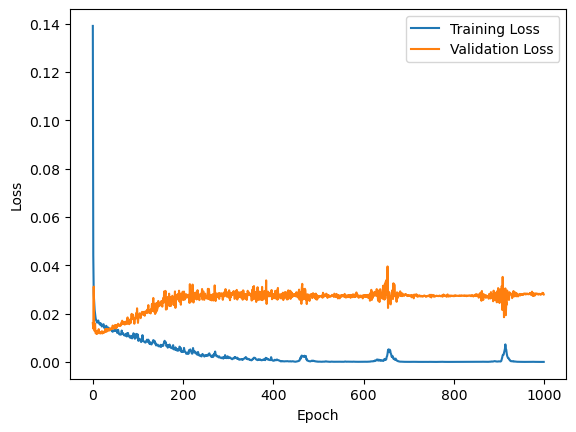

In [53]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'][0:], label='Training Loss')
plt.plot(history.history['val_loss'][0:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


I hope this was helpful,

*Aun Al Ghaithi*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
